# import library

In [ ]:
!pip install control

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 513.9/513.9 kB 6.3 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal #for laplace transformation
import pandas as pd #for save data
from numpy.fft import fft, ifft, fftshift, fftfreq
from scipy.signal import max_len_seq
import math
from control import matlab #control theory
import control
import os
import cmath
np.random.seed(42)

## Check GPU is available

In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## make Pairs of input and output
- 0.1[Hz] ~ 10 [Hz] every 0.1 Hz -> 100
- 100 periods for each frequency response
- save data into dict (responses)

In [ ]:
class MakeData():
  def __init__(self,n_exercises,sampling_rate=100,n_periods=100,n_time = 10, bool_time=True,range_frequency=(0.1,10)):
    """make data pairs of input signal and output for each transfer function
       data is derived as following and frequency ranges in range_frequency=(0.1,10) every 0.1 Hz;
       t = np.arange(0,1/f*Num_periods,1/sampling_rate)
       input_signal = np.sin(2*math.pi*f*t)

    Args:
      n_exercises(int) : number of exercises; (1,2,3), 1: second order, 2: parallel second order, 3: non-proper
      sampling_rate = 100  # 100 samples per second = 100 Hz
      n_periods = 10 #100 periods of data
      n_time : training time
      bool_time : gather data based on periods or time
      range_frequnecy (min_frequency[Hz],max_frequency[Hz]) = (0.1,10) #min and max
    """
    #parameter setting
    self.sampling_rate = sampling_rate
    self.n_periods = n_periods
    self.n_time = n_time
    self.bool_time =bool_time
    (self.min_frequency,self.max_frequency) = range_frequency
    #exercises1
    if n_exercises==1:
      omega_n = 2.0  # Natural frequency
      zeta = 0.3  # Damping ratio
      self.G = self.tf_2nd_order(zeta=zeta,wn=omega_n)
    #exercises2
    if n_exercises==2:
      #params setting
      omega_n1 = 2.0  # Natural frequency of the first system
      zeta1 = 0.3  # Damping ratio of the first system
      omega_n2 = 7.0  # Natural frequency of the second system
      zeta2 = 0.6  # Damping ratio of the second system
      self.G = self.tf_2nd_order_parallel(zeta1,omega_n1,zeta2,omega_n2)
    #exercises3
    if n_exercises == 3:
      self.G = self.tf_notproper()

    #get data
    self.responses = self.makePairs()

  #exercises1
  def tf_2nd_order(self,zeta, wn):
    """2nd order Transfer Frnction
    """
    num = [wn*wn]
    den = [1, 2*zeta*wn, wn*wn]
    #G = matlab.tf(num, den)
    G = control.matlab.tf(num, den)
    print("G=",G)
    return G

  #exerciess2
  def tf_2nd_order_parallel(self,zeta1,wn1,zeta2,wn2):
    G1 =  self.tf_2nd_order(zeta1,wn1)
    G2 =  self.tf_2nd_order(zeta2,wn2)
    G = control.matlab.parallel(G1,G2)
    print("G=",G)
    return G

  #exercises3
  def tf_notproper(self):
    num = [1,-3,-4]
    den = [1,5,6]
    #G = matlab.tf(num, den)
    G = control.matlab.tf(num, den)
    print("G=",G)
    return G

  def makePairs(self):
    """make pairs of input and output

    Args:
      sampling_rate = 100  # 100 samples per second = 100 Hz
      n_periods = 10 #100 periods of data
      range_frequnecy (min_frequency[Hz],max_frequency[Hz]) = (0.1,10) #min and max
    Return
     Responses (dict): {frequency : np.array(shape=[n_samples,3(time,input,output)])}
    """
    #0 data
    time_margin = 100
    #frequencies
    frequencies = np.arange(self.min_frequency,self.max_frequency+0.1,0.1)
    #storage
    responses = dict() #frequency : np.array(shape=[n_samples,3(time,input,output)])
    self.size_dict = dict() #for saving number of data for each frequency
    for f in frequencies:
      f = round(f,2)
      if bool_time:#make data whose duration is same
        self.t = np.arange(0,self.n_time,1/self.sampling_rate)
      else: #make data whose number of periods is same
        self.t = np.arange(0,1/f*self.n_periods,1/self.sampling_rate)
      self.input_signal = np.append(np.zeros(time_margin),np.sin(2*math.pi*f*self.t))
      self.t = np.append(self.t,np.arange(self.t[-1]+1/self.sampling_rate,self.t[-1]+(time_margin+1)/self.sampling_rate,1/self.sampling_rate))
      print(f"{f} [Hz] :: input_signal.size = {self.input_signal.shape}")
      self.size_dict[f] = self.input_signal.shape[0]
      #output
      y_out,t_out, x = control.matlab.lsim(self.G, U=self.input_signal,T=self.t)
      response = []
      for t,input,output in zip(t_out,self.input_signal,y_out):
        response.append([t,input,output])
      response = np.array(response)
      print(np.max(response[:,1]),np.min(response[:,1]))
      responses[f]=response
    return responses

In [ ]:
"""make data pairs of input signal and output for each transfer function
    data is derived as following and frequency ranges in range_frequency=(0.1,10) every 0.1 Hz;
    t = np.arange(0,1/f*Num_periods,1/sampling_rate)
    input_signal = np.sin(2*math.pi*f*t)

Args:
  n_exercises(int) : number of exercises; (1,2,3), 1: second order, 2: parallel second order, 3: non-proper
  sampling_rate = 100  # 100 samples per second = 100 Hz
  n_periods = 10 #100 periods of data
  range_frequnecy (min_frequency[Hz],max_frequency[Hz]) = (0.1,10) #min and max
"""
#params setting
N_exercises = 1 #number of exercises(1,2,3)
Sampling_rate = 100 #sampling rate [Hz]
N_periods = 100 #how many periods will we get data for each frequency?
N_time = 20 #10 seconds
bool_time = True
Range_frequency = (0.1,10) #frequency range of sin function. default: from 0.1 Hz to 10 Hz every 0.1Hz (0.1,0.2,0.3,...,10)[Hz]

In [ ]:
mkData = MakeData(n_exercises=N_exercises,sampling_rate=Sampling_rate,n_periods=N_periods,n_time=N_time,bool_time=bool_time,range_frequency=Range_frequency)

G= <TransferFunction>: sys[0]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4

0.1 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
0.2 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
0.3 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
0.4 [Hz] :: input_signal.size = (2100,)


/usr/local/lib/python3.10/dist-packages/control/timeresp.py:1003: UserWarning: return_x specified for a transfer function system. Internal conversion to state space used; results may meaningless.
  warnings.warn(


0.9999210442038161 -0.9999210442038162
0.5 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
0.6 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
0.7 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
0.8 [Hz] :: input_signal.size = (2100,)
0.9999210442038161 -0.9999210442038162
0.9 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.0 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.1 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.2 [Hz] :: input_signal.size = (2100,)
0.9999210442038162 -0.9999210442038162
1.3 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.4 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.5 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.6 [Hz] :: input_signal.size = (2100,)
0.9999210442038163 -0.9999210442038166
1.7 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.8 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
1.9 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
2.0 [Hz] :: input_signal.size = (2100,)
0.9980267284282736 -0.9980267284282734
2.1 [Hz] :: input_signal.size = (2100,)
1.0 -1.0
2.2 [Hz]

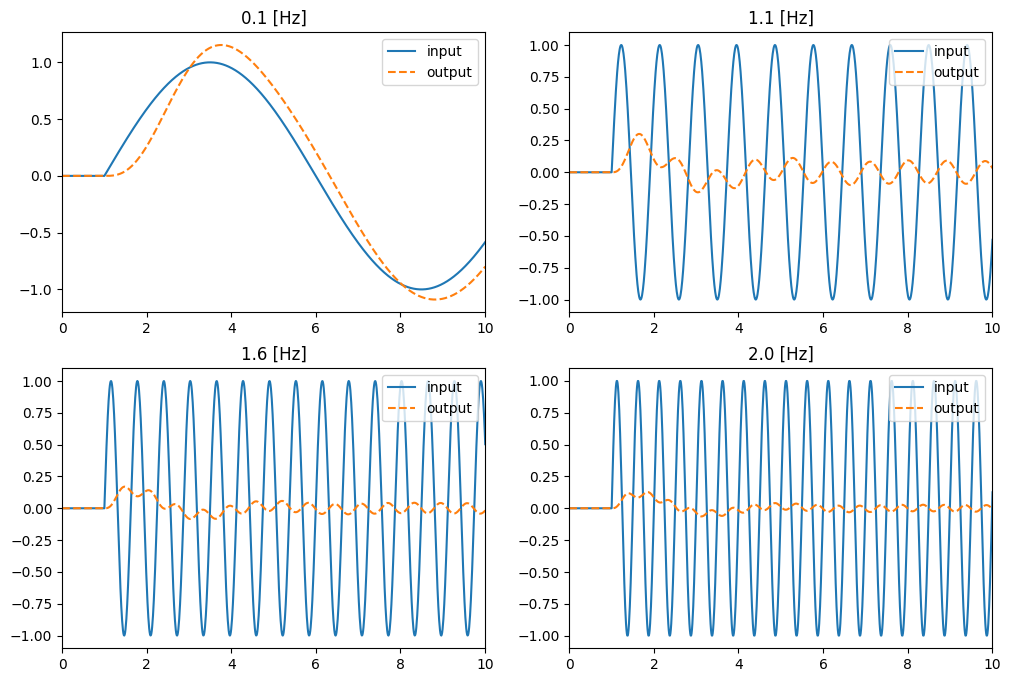

In [ ]:
#plot input and output data
frequencies =[0.1,1.1,1.6,2.0] # 5 [hz] data
fig,ax = plt.subplots(2,2,figsize=(12,8))
for i,f in enumerate(frequencies):
  ax[i//2][i%2].plot(mkData.responses[f][:,0],mkData.responses[f][:,1],label="input")
  ax[i//2][i%2].plot(mkData.responses[f][:,0],mkData.responses[f][:,2],linestyle="--",label="output")
  ax[i//2][i%2].set_xlim(0,10)
  ax[i//2][i%2].set_title(f"{f} [Hz]")
  ax[i//2][i%2].legend(loc="upper right")
fig.show()

## Linear Sine wave

In [ ]:
class MakeData():
  def __init__(self,n_exercises,sampling_rate=100,n_periods=100,n_time = 10, bool_time=True,range_frequency=(0.1,10),n_sum = 3,n_wave=100):
    """make data pairs of input signal and output for each transfer function
       data is derived as following and frequency ranges in range_frequency=(0.1,10) every 0.1 Hz;
       t = np.arange(0,1/f*Num_periods,1/sampling_rate)
       input_signal = np.sin(2*math.pi*f*t)

    Args:
      n_exercises(int) : number of exercises; (1,2,3), 1: second order, 2: parallel second order, 3: non-proper
      sampling_rate = 100  # 100 samples per second = 100 Hz
      n_periods = 10 #100 periods of data
      n_time : training time
      bool_time : gather data based on periods or time
      range_frequnecy (min_frequency[Hz],max_frequency[Hz]) = (0.1,10) #min and max
    """
    #parameter setting
    self.sampling_rate = sampling_rate
    self.n_periods = n_periods
    self.n_time = n_time
    self.bool_time =bool_time
    (self.min_frequency,self.max_frequency) = range_frequency
    self.n_sum = n_sum
    self.n_wave = n_wave
    #exercises1
    if n_exercises==1:
      omega_n = 2.0  # Natural frequency
      zeta = 0.3  # Damping ratio
      self.G = self.tf_2nd_order(zeta=zeta,wn=omega_n)
    #exercises2
    if n_exercises==2:
      #params setting
      omega_n1 = 2.0  # Natural frequency of the first system
      zeta1 = 0.3  # Damping ratio of the first system
      omega_n2 = 7.0  # Natural frequency of the second system
      zeta2 = 0.6  # Damping ratio of the second system
      self.G = self.tf_2nd_order_parallel(zeta1,omega_n1,zeta2,omega_n2)
    #exercises3
    if n_exercises == 3:
      self.G = self.tf_notproper()

    #get data
    self.responses = self.makePairs()

  #exercises1
  def tf_2nd_order(self,zeta, wn):
    """2nd order Transfer Frnction
    """
    num = [wn*wn]
    den = [1, 2*zeta*wn, wn*wn]
    #G = matlab.tf(num, den)
    G = control.matlab.tf(num, den)
    print("G=",G)
    return G

  #exerciess2
  def tf_2nd_order_parallel(self,zeta1,wn1,zeta2,wn2):
    G1 =  self.tf_2nd_order(zeta1,wn1)
    G2 =  self.tf_2nd_order(zeta2,wn2)
    G = control.matlab.parallel(G1,G2)
    print("G=",G)
    return G

  #exercises3
  def tf_notproper(self):
    num = [1,-3,-4]
    den = [1,5,6]
    #G = matlab.tf(num, den)
    G = control.matlab.tf(num, den)
    print("G=",G)
    return G

  def makePairs(self):
    """make pairs of input and output

    Args:
      sampling_rate = 100  # 100 samples per second = 100 Hz
      n_periods = 10 #100 periods of data
      range_frequnecy (min_frequency[Hz],max_frequency[Hz]) = (0.1,10) #min and max
    Return
     Responses (dict): {frequency : np.array(shape=[n_samples,3(time,input,output)])}
    """
    #frequencies
    # frequencies = np.arange(self.min_frequency,self.max_frequency+0.1,0.1)
    #storage
    responses = dict() #frequency : np.array(shape=[n_samples,3(time,input,output)])
    self.size_dict = dict() #for saving number of data for each frequency

    for i in range(self.n_wave):
      frequencies = []
      for _ in range(self.n_sum):
        random_value = np.random.uniform(self.min_frequency, self.max_frequency)
        random_value = round(random_value,2)
        frequencies.append(random_value)

      if bool_time:#make data whose duration is same
        self.t = np.arange(0,self.n_time,1/self.sampling_rate)
      else: #make data whose number of periods is same
        self.t = np.arange(0,1/max(frequencies)*self.n_periods,1/self.sampling_rate)

      linear_sum_sin = np.zeros_like(self.t)
      for n in range(self.n_sum):
        linear_sum_sin += np.sin(2*math.pi*frequencies[n]*self.t)
      self.input_signal = linear_sum_sin
      print(f"{i} th wave :: input_signal.size = {self.input_signal.shape}")
      self.size_dict[i] = self.input_signal.shape[0]
      #output
      y_out,t_out, x = control.matlab.lsim(self.G, U=self.input_signal,T=self.t)
      response = []
      for t,input,output in zip(t_out,self.input_signal,y_out):
        response.append([t,input,output])
      response = np.array(response)
      print(np.max(response[:,1]),np.min(response[:,1]))
      responses[i]=response
    return responses

In [ ]:

"""make data pairs of input signal and output for each transfer function
    data is derived as following and frequency ranges in range_frequency=(0.1,10) every 0.1 Hz;
    t = np.arange(0,1/f*Num_periods,1/sampling_rate)
    input_signal = np.sin(2*math.pi*f*t)

Args:
  n_exercises(int) : number of exercises; (1,2,3), 1: second order, 2: parallel second order, 3: non-proper
  sampling_rate = 100  # 100 samples per second = 100 Hz
  n_periods = 10 #100 periods of data
  range_frequnecy (min_frequency[Hz],max_frequency[Hz]) = (0.1,10) #min and max
"""
#params setting
N_exercises = 1 #number of exercises(1,2,3)
Sampling_rate = 100 #sampling rate [Hz]
N_periods = 100 #how many periods will we get data for each frequency?
N_time = 10 #10 seconds
bool_time = True
Range_frequency = (0.1,10) #frequency range of sin function. default: from 0.1 Hz to 10 Hz every 0.1Hz (0.1,0.2,0.3,...,10)[Hz]
N_sum=5
N_wave=100

In [ ]:
mkData = MakeData(n_exercises=N_exercises,sampling_rate=Sampling_rate,n_periods=N_periods,n_time=N_time,bool_time=bool_time,range_frequency=Range_frequency,n_sum=N_sum,n_wave=N_wave)

G= <TransferFunction>: sys[101]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


       4
---------------
s^2 + 1.2 s + 4

0 th wave :: input_signal.size = (1000,)
4.577075611127083 -4.8307497423835475
1 th wave :: input_signal.size = (1000,)
4.2721451412899025 -4.667071566545074
2 th wave :: input_signal.size = (1000,)
4.275684752133139 -3.9333703593044467
3 th wave :: input_signal.size = (1000,)
4.392419413963913 -4.352905136155523
4 th wave :: input_signal.size = (1000,)
4.135260240338983 -4.597319349352458
5 th wave :: input_signal.size = (1000,)
4.2817653621446015 -4.327937137179699
6 th wave :: input_signal.size = (1000,)
3.993164122880923 -4.542142104270062
7 th wave :: input_signal.size = (1000,)
4.129188629073581 -4.631120144142911
8 th wave :: input_signal.size = (1000,)
4.060780623252534 -3.965410734145024
9 th wave :: input_signal.size = (1000,)
4.263673810524793 -4.2255353208648785
10 th wave :: input_signal.size = (1000,)
4.840681371502701 -4.811210567448225
11 th wave :: inp

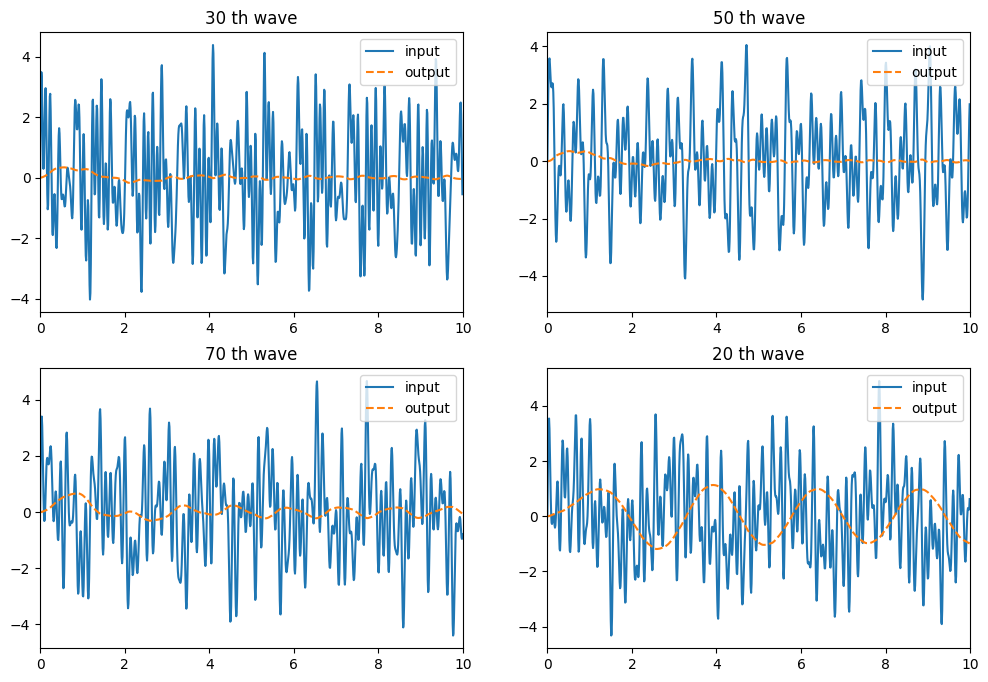

In [ ]:

#plot input and output data
waves =[30, 50, 70, 20] # 1, 5, 10, 20th wave
fig,ax = plt.subplots(2,2,figsize=(12,8))
for i,f in enumerate(waves):
  ax[i//2][i%2].plot(mkData.responses[f][:,0],mkData.responses[f][:,1],label="input")
  ax[i//2][i%2].plot(mkData.responses[f][:,0],mkData.responses[f][:,2],linestyle="--",label="output")
  ax[i//2][i%2].set_xlim(0,10)
  ax[i//2][i%2].set_title(f"{f} th wave")
  ax[i//2][i%2].legend(loc="upper right")
fig.show()


## make dataset

In [ ]:
#calculate mean and sigma of all data
class Dataset():
  """
    Make dataset
    Args:
      responses (dict) : {frequency : np.array() (shape=[n_samples,3(time,input,output)])}
      lookback: how long data use as an input
      lookahead: how long in advance to predict
      dif_out: time difference of output, How many seconds ago is the output value used?
      method_scaling : 0: standardization, 1: normalization
      frequency_valid, frequency_test: validation and test data
  """
  def __init__(self,responses,lookback = 100,lookahead = 1,dif_out = 30,method_scaling = 0,frequency_valid=[1.5,3.5,5.5],frequency_test=[1,3,5]):
    self.responses = responses
    self.lookback = lookback
    self.lookahead = lookahead
    self.dif_out=dif_out
    self.method_scaling = method_scaling
    self.frequency_valid = frequency_valid
    self.frequency_test = frequency_test

    #normalize
    responses_train,responses_valid,responses_test = self.normalize()
    #make dataset
    self.input_train,self.label_train = self.mkDataset(responses_train)
    permutation = np.random.permutation(self.input_train.shape[0])
    self.input_train = self.input_train[permutation]
    self.label_train = self.label_train[permutation]
    self.input_valid,self.label_valid = self.mkDataset(responses_valid)
    self.input_test,self.label_test = self.mkDataset(responses_test)
    print(f"inputs_train.shape={self.input_train.shape}, labels_train={self.label_train.shape},intputs_valid.shape={self.input_valid.shape}, labels_train={self.label_valid.shape},intputs_test.shape={self.input_test.shape}, labels_test={self.label_test.shape}")

  def normalize(self):
    """
    Normalize data with mean and sigma which are calculated from all data regardless of frequency
    Args:
      responses (dict) : {frequency : np.array() (shape=[n_samples,3(time,input,output)])}
    Return
      responses (dict) :　normalized data {frequency:[seq,(time,input,output)]}
    """
    data_input = []
    data_output = []
    count=0
    for key in self.responses.keys():
      for i in range(self.responses[key].shape[0]): #for each time steps
        #print(key, responses[key].shape)
        data_input.append(self.responses[key][i][1]) # input
        data_output.append(self.responses[key][i][2]) #output
        count+=1
    data_input = np.array(data_input)
    data_output = np.array(data_output)
    if self.method_scaling == 0: #standardization
      self.mean_input = np.mean(data_input)
      self.sigma_input = np.std(data_input)
      self.mean_output = np.mean(data_output)
      self.sigma_output = np.std(data_output)
    elif self.method_scaling == 1: #normalization
      self.max_input = np.max(data_input)
      self.min_input = np.min(data_input)
      self.max_output = np.max(data_output)
      self.min_output = np.min(data_output)
    #normalize
    for key in self.responses.keys():
      for i in range(self.responses[key].shape[0]): #for each time steps
        #normalize input
        if self.method_scaling==0: #standardization
          self.responses[key][i][1] = (self.responses[key][i][1]-self.mean_input)/self.sigma_input
          if (self.responses[key][i][1]-self.mean_input)/self.sigma_input>1e2:
            print((self.responses[key][i][1]-self.mean_input)/self.sigma_input)
          #normalize output
          self.responses[key][i][2] = (self.responses[key][i][2]-self.mean_output)/self.sigma_output
          if (self.responses[key][i][2]-self.mean_output)/self.sigma_output>1e2:
            print((self.responses[key][i][2]-self.mean_output)/self.sigma_output)
        elif self.method_scaling==1: #normalization
          self.responses[key][i][1] = (self.responses[key][i][1]-self.min_input)/(self.max_input-self.min_input)
          #normalize output
          self.responses[key][i][2] = (self.responses[key][i][2]-self.min_output)/(self.max_output-self.min_output)
    #split data into train, valid and test data based on frequencies
    responses_train = dict()
    responses_valid = dict()
    responses_test = dict()
    count=0
    for key in self.responses.keys():
      if key in self.frequency_valid:#valid data
        responses_valid[key] = self.responses[key]
      elif key in self.frequency_test:#test data
        responses_test[key] = self.responses[key]
      else:#train data
        responses_train[key]=self.responses[key]

    if method_scaling==0:#standardization
      print(f"After normalization :: mean_input={self.mean_input}, sigma_input={self.sigma_input}, mean_output={self.mean_output}, sigma_output={self.sigma_output}")
    if method_scaling==1:#normalization
      print(f"After normalization :: max_input={self.max_input}, min_input={self.min_input}, max_output={self.max_output}, min_output={self.min_output}")
    return responses_train,responses_valid,responses_test

  def mkDataset(self,responses):
    """
    make input data and labels for sequential prediction model
    """
    count = 0
    for key in responses.keys():
      if key%10==0:
        print(f"{key} Hz")
      if count == 0 or inputs.shape[0] == 0:
        inputs = self.mk_inputData(responses[key][:,1],responses[key][:,2])
        labels = self.mk_labelData(responses[key][:,2])
      else:
        input = self.mk_inputData(responses[key][:,1],responses[key][:,2])
        label = self.mk_labelData(responses[key][:,2])
        if input.shape[0] > 0:
          inputs = np.vstack((inputs,input))
          labels = np.append(labels,label,axis=0)
      count+=1
    print(count)
    print(f"input shape={inputs.shape}, labels shape={labels.shape}")
    return inputs,labels

  def mk_inputData(self,data0,data1):
    """make train dataset
    Args:
      data: original data
      lookback: how long data use as an input
      lookahead: how long in advance to predict
      dif_out: time difference of output, How many seconds ago is the output value used?
    Return:
      nd.array : [n_samples, 2]
    """
    data0 = data0.tolist()
    data1 = data1.tolist()
    train = []
    if len(data0)-self.lookback-self.lookahead <=self.dif_out: #appropriate data doesn't exist due to insufficient volume of data
      return np.array([])
    else:
      for k in range(self.dif_out,len(data0)-self.lookback-self.lookahead+1):
        temp = []
        for i in range(self.lookback):#input data : self.dif_out ~ self.dif_out + self.lookback-1. output : 0~self.look_back-1
          dim = []
          dim.append(data0[k+i])
          dim.append(data1[k+i-self.dif_out])
          temp.append(dim)
        #temp.append(temp_2)
        train.append(temp)
      train = np.array(train)
      return train

  def mk_labelData(self,data):
    data = data.tolist()
    test = []
    if (self.dif_out+self.lookback+self.lookahead)>=len(data):#appropriate data doesn't exist due to insufficient volume of data
      return np.array([])
    else:
      for k in range(self.dif_out+self.lookback+self.lookahead-1,len(data)):#input data is until self.dif_out+self.lookback-1 -> label should be the self.dif_out+self.lookback
        pred_start = k- (self.dif_out+self.lookahead-1) #latest frame in prediction :: self.dif_out+self.lookback+self.lookahead-1
        pred_end = k+1
        labels = []
        for l in range(pred_start,pred_end):
          labels.append(data[l])
        test.append(labels)
      test = np.array(test)
      #print(len(test))
      return test

In [ ]:
"""
  Make dataset
  Args:
    responses (dict) : {frequency : np.array() (shape=[n_samples,3(time,input,output)])}
    lookback: how long data use as an input
    lookahead: how long in advance to predict
    dif_out: time difference of output, How many seconds ago is the output value used?
    rate_train,rate_valid : rate of train and valid data of all
"""
Lookback_ = 100 #default = 100
Lookahead_ = 1 #default = 1
Dif_out_ = 30 # default = 30
out_predict=Dif_out_+Lookahead_
#Rate_train_ = 0.8 #default = 0.8
#Rate_valid_ = 0.1 #default = 0.1
method_scaling = 0 #0 :: standardization(→z=(x-mean_x)/sigma_x) : (mean=0, sigma=1), 1 : normalization(→z=(x-min)/(max-min)) :(value ranges from 0 to 1)
frequency_valid = [4,8,50]#valid data frequencies
frequency_test = [10,30,80]#test data. use data as a test data

dataset = Dataset(responses=mkData.responses,lookback = Lookback_,lookahead = Lookahead_,dif_out = Dif_out_,method_scaling = method_scaling,frequency_valid=frequency_valid,frequency_test=frequency_test)

After normalization :: mean_input=0.042614551154651174, sigma_input=1.5993662016057897, mean_output=0.039209626845621334, sigma_output=0.46639552555118974
0 Hz
20 Hz
40 Hz
60 Hz
70 Hz
90 Hz
94
input shape=(81780, 100, 2), labels shape=(81780, 31)
50 Hz
3
input shape=(2610, 100, 2), labels shape=(2610, 31)
10 Hz
30 Hz
80 Hz
3
input shape=(2610, 100, 2), labels shape=(2610, 31)
inputs_train.shape=(81780, 100, 2), labels_train=(81780, 31),intputs_valid.shape=(2610, 100, 2), labels_train=(2610, 31),intputs_test.shape=(2610, 100, 2), labels_test=(2610, 31)


## Sequential model

In [ ]:
from keras.layers import LeakyReLU
from keras.models import Sequential
from  tensorflow.python.keras.backend import set_session,get_session,set_learning_phase
import tensorflow as tf
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
import random
import numpy as np
import string
import re
from collections import Counter
from typing import List
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.layers import LSTM
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau #学習時間などのリソース節約のため
from tensorflow.keras.utils import plot_model
import numpy as np
import matplotlib.pyplot as plt
import os

#csvファイルのダウンロード
import pandas as pd
#標準化ライブラリ
from sklearn.preprocessing import MinMaxScaler

#prepare data for LSTM
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pandas as pd
import matplotlib.pyplot as plt

seed = 42
np.random.seed(seed)
random.seed(seed)

#from google.colab import drive
#drive.mount('/content/drive')

#### LOSS function weight

In [ ]:
#loss weight
bool_Frequency=False
lambda_continuity_ = 0.1
lambda_frequency_ = 1.0
lambda_mse=0.0

In [ ]:
# KL divergence function
def kl_divergence(p, q):
    return tf.reduce_sum(p * tf.math.log(p / q))

# Example function to compute FFT and distribution, considering Nyquist frequency
@tf.function
def compute_fft(input_tensor, sampling_rate=Sampling_rate):
    fft_tensor = tf.signal.fft(tf.cast(input_tensor, tf.complex64))
    #print(fft_tensor)
    #n = tf.shape(input_tensor)[-1]
    #frequencies = tf.signal.fftfreq(n, 1 / sampling_rate)

    # Extract frequencies up to Nyquist frequency
    #mask = (frequencies >= 0) & (frequencies <= sampling_rate / 2)
    #fft_tensor = tf.boolean_mask(fft_tensor, mask)
    #frequencies = tf.boolean_mask(frequencies, mask)

    distribution = tf.abs(fft_tensor) / tf.reduce_sum(tf.abs(fft_tensor))
    return distribution

def custom_loss(y_true, y_pred):
  """Mean Squared Error (MSE)
    # Example true values and predicted values
    y_true = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0])
    y_pred = tf.constant([1.1, 1.9, 3.2, 4.0, 4.8])

    # Compute Mean Squared Error (MSE)
    mse = tf.reduce_mean(tf.square(y_true - y_pred))
  """
  #mse
  #print(type(y_true))
  #print(y_true.shape, y_pred.shape)#(None,30)
  mse = tf.reduce_mean(tf.square(y_true - y_pred)) #
  loss=mse
  if bool_Frequency:
    #KL divergence
    # Compute FFT and distributions
    distribution_true = compute_fft(y_true, Sampling_rate)
    distribution_pred = compute_fft(y_pred, Sampling_rate)

    # Example usage
    kl_div = kl_divergence(distribution_true,distribution_pred)
    loss = lambda_mse*mse+lambda_frequency_*kl_div
    #print(f"KL Divergence: {kl_div.shape}")
    """
    #continuity
    continuity = 0
    count = 0
    # Loop for continuity calculation and update the variable
    for i in range(1,  tf.shape(y_pred)[-1]- 1):
      continuity += tf.abs(2*y_pred[:, i] - y_pred[:, i + 1] - y_pred[:, i-1])
      count +=1
    continuity /= count

    loss = mse + lambda_continuity_*continuity + lambda_frequency_ * kl_div
    """
  return loss

In [ ]:
# design network
def seqModel(input_shape,dim_output,hidden_size,n_layers,lr_init,type_model):
  """sequential model

  Args:
    input_shape : input shape (sequence, feature dimention)
    dim_output : dimention of output
    lr_init : initial learning rate
    type_model : sequential model type ("lstm","bilstm", "gru"(Gated Recurrent Unit))
    hidden_size: hidden size
    n_layers: number of layers
  """
  #from keras.engine.sequential import model_serialization
  from tensorflow import keras
  from tensorflow.keras import Input, Model
  from tensorflow.keras.layers import TimeDistributed, Activation,Reshape,Dropout,Activation
  from keras import backend as K
  early_stopping = EarlyStopping(monitor='val_loss', mode='auto', patience=20)

  inputs = Input(shape=input_shape)
  if type_model.lower() == "lstm":
    if n_layers>=2:
      for i in range(n_layers-1):
        x = LSTM(hidden_size,return_sequences=True)(inputs)
        #x = Dropout(0.1)(x)
      x = LSTM(hidden_size,return_sequences=False)(x) #if stack lstm layer, return_sequences=True, and otherwise False
    else:
      x = LSTM(hidden_size,return_sequences=False)(inputs) #if stack lstm layer, return_sequences=True, and otherwise False
  elif type_model.lower() =="bilstm":
    if n_layers>=2:
      for i in range(n_layers-1):
        x = tf.keras.layers.Bidirectional(LSTM(hidden_size,return_sequences=True),merge_mode="concat")(inputs) #merge_mode = "concat" or "sum". if "concat" output length should be twice of "sum"
      x = tf.keras.layers.Bidirectional(LSTM(hidden_size,return_sequences=False),merge_mode="concat")(x) #last layer should be return_sequences = False
    else:
      x = tf.keras.layers.Bidirectional(LSTM(hidden_size,return_sequences=False),merge_mode="concat")(inputs) #merge_mode = "concat" or "sum". if "concat" output length should be twice of "sum"
    print(x.shape)
  elif type_model.lower() == "gru":
    if n_layers>=2:
      for i in range(n_layers-1):
        x = tf.keras.layers.GRU(hidden_size,dropout=0.0,recurrent_dropout=0.0,return_sequences=True)(inputs)
      x = tf.keras.layers.GRU(hidden_size,dropout=0.0,recurrent_dropout=0.0,return_sequences=False)(x)
    else:
      x = tf.keras.layers.GRU(hidden_size,dropout=0.0,recurrent_dropout=0.0,return_sequences=False)(inputs)
  outputs = Dense(dim_output,trainable=True)(x)
  outputs = Activation("linear")(outputs)
  model= Model(inputs = inputs, outputs = outputs)
  model.compile(loss=custom_loss, optimizer=Adam())
  return model

## Train

In [ ]:
input_length = dataset.input_train.shape[1] # sequential length for inpu data :: default 100 frames (=1 sec)
dim_features = dataset.input_train.shape[2] #dimension for features per frame :: default 2, input and output
dim_output = out_predict #dimension of output

#training setting
n_epochs = 200#number of train epochs
batch_size = 512 #batch size
verbose = 0 # output comments? 0 or 1
shuffle = False # shuffle data?
#call back setting
patience = 20 #how many epochs to wait by finishing traininig
#directory for saving training log
rootDir = '/content/gdrive/MyDrive/D1S/dss/tensorlog'
if not os.path.exists(rootDir): #make directory if not exists
  os.makedirs(rootDir)

#model type
type_model = "lstm" #"lstm","bilstm","gru"

#learning rate
lr_init = 0.05 #initial learning rate
lr_last = 0.00001 #last lr
learning_rates = np.linspace(lr_init, lr_last, n_epochs)
lr_cb = tf.keras.callbacks.LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

#hyperparameters
model_names = ["lstm","bilstm","gru"]
hidden_sizes=[50,100]
layers = [1,2]
losses = dict()
val_losses = dict()

### For grid search

In [ ]:
#old_session = get_session()
#with tf.Graph().as_default(): # creates a new TensorFlow graph and sets it as the default graph within the context
for name in model_names:
  for hidden_size in hidden_sizes:
    for layer in layers:

      set_learning_phase(1)

      #make instance of model
      model = seqModel(input_shape = (input_length,dim_features),dim_output=dim_output,hidden_size=hidden_size,n_layers=layer,lr_init=lr_init,type_model=name)
      model.summary()

      #callback setting
      fpath = os.path.join(rootDir,'weights-epoch{epoch:02d}.hdf5') #save file name
      cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto') #save log
      es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=verbose, mode='auto') #early stopping if model overfits
      tb_cb = TensorBoard(log_dir=rootDir, histogram_freq=10) #histogram_freq : frequency of outputting log # output training status

      #execute training
      history = model.fit(dataset.input_train, dataset.label_train, batch_size=batch_size, epochs=n_epochs, validation_data=(dataset.input_valid,dataset.label_valid), verbose=verbose, callbacks=[lr_cb,cp_cb, es_cb, tb_cb])

      specification = f"{name}Model-{hidden_size}Hidden_size-{layer}Layers"
      #save data
      losses[specification] = history.history['loss']
      val_losses[specification] = history.history['val_loss']

#save model
json_string = model.to_json()
open(os.path.join(rootDir,'lstm_model.json'), 'w').write(json_string)

#plot training status
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [ ]:
fig,ax = plt.subplots(3,4,figsize=(40,20))
count = 0
for name in model_names:
  for hidden_size in hidden_sizes:
    for n_layer in layers:
      #print(f"{name}Model-{hidden_size}Hidden_size-{n_layer}Layers")
      specification = f"{name}Model-{hidden_size}Hidden_size-{n_layer}Layers"
      ax[count//4][count%4].plot(losses[specification],label="loss")
      ax[count//4][count%4].plot(val_losses[specification],label="val_loss")
      #ax[count//4][count%4].set_ylim(0.0,0.01)
      ax[count//4][count%4].set_title(specification)
      ax[count//4][count%4].legend(loc="upper right")
      count+=1


fig.savefig("grid_search_MSE_multiVariate.png")
fig.show()

### normal

In [ ]:
input_length = dataset.input_train.shape[1] # sequential length for inpu data :: default 100 frames (=1 sec)
dim_features = dataset.input_train.shape[2] #dimension for features per frame :: default 2, input and output
dim_output = out_predict #dimension of output

#training setting
n_epochs = 200#number of train epochs
batch_size = 512 #batch size
verbose = 0 # output comments? 0 or 1
shuffle = False # shuffle data?
#call back setting
patience = 20 #how many epochs to wait by finishing traininig
#directory for saving training log
rootDir = '/content/gdrive/MyDrive/D1S/dss/tensorlog'
if not os.path.exists(rootDir): #make directory if not exists
  os.makedirs(rootDir)

#model type
type_model = "lstm" #"lstm","bilstm","gru"

#learning rate
lr_init = 0.01 #initial learning rate
lr_last = 0.0001 #last lr
learning_rates = np.linspace(lr_init, lr_last, n_epochs)
lr_cb = tf.keras.callbacks.LearningRateScheduler(lambda epoch: float(learning_rates[epoch]))

#hyperparameters
name = "bilstm"
hidden_size=50
n_layer=2
losses = dict()
val_losses = dict()

/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/backend.py:427: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


(None, 100)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 2)]          0         
                                                                 
 bidirectional (Bidirection  (None, 100, 100)          21200     
 al)                                                             
                                                                 
 bidirectional_1 (Bidirecti  (None, 100)               60400     
 onal)                                                           
                                                                 
 dense (Dense)               (None, 31)                3131      
                                                                 
 activation (Activation)     (None, 31)                0         
                                                                 
Total params: 84731 (330.98 KB)
Trainable params:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


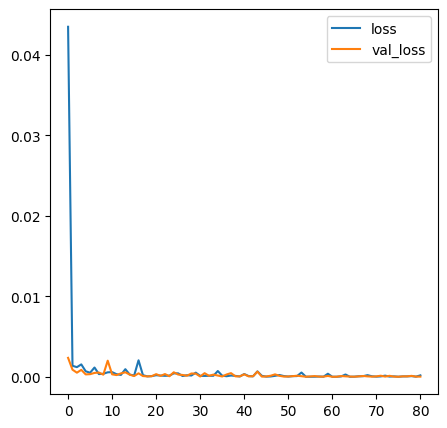

In [ ]:
set_learning_phase(1)

#make instance of model
model = seqModel(input_shape = (input_length,dim_features),dim_output=dim_output,hidden_size=hidden_size,n_layers=n_layer,lr_init=lr_init,type_model=name)
model.summary()

#callback setting
#fpath = os.path.join(rootDir,'weights-epoch{epoch:02d}.hdf5') #save file name
#cp_cb = ModelCheckpoint(filepath = fpath, monitor='val_loss', verbose=verbose, save_best_only=True, mode='auto') #save log
es_cb = EarlyStopping(monitor='val_loss', patience=patience, verbose=0, mode='auto') #early stopping if model overfits
tb_cb = TensorBoard(log_dir=rootDir, histogram_freq=10) #histogram_freq : frequency of outputting log # output training status
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.4, patience=5, min_lr=1e-5)
#execute training
history = model.fit(dataset.input_train, dataset.label_train, batch_size=batch_size, epochs=n_epochs, validation_data=(dataset.input_valid,dataset.label_valid), verbose=verbose, callbacks=[lr_cb, es_cb, tb_cb])#,cp_cb,lr_cb,reduce_lr

#specification = f"{name}Model-{hidden_size}Hidden_size-{layer}Layers"
#save data
#losses[specification] = history.history['loss']
#val_losses[specification] = history.history['val_loss']

#save model
json_string = model.to_json()
open(os.path.join(rootDir,'lstm_model.json'), 'w').write(json_string)
file_name = name+"-epochs"+str(len(history.history['loss']))+".hdf5"
saveFile = os.path.join(rootDir,file_name)
model.save(saveFile)
#plot training status
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

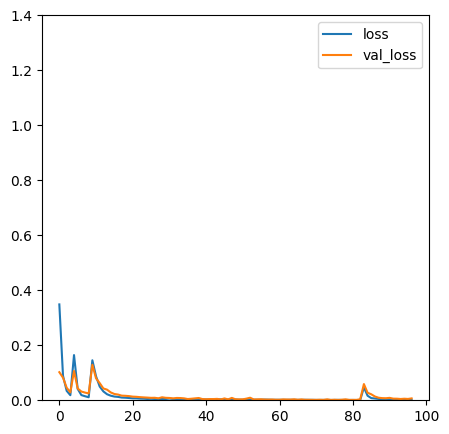

In [ ]:
plt.figure(figsize=(5,5))
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim(0,1.4)
plt.legend()
plt.show()

### plot losses

In [ ]:
print(len(losses.keys()))

0


## Evaluation

### load pretrained model

In [ ]:
#check save file
%cd /content/gdrive/MyDrive/D1S/dss/tensorlog
%ls

/content/gdrive/MyDrive/D1S/dss/tensorlog
bilstm-epochs31.hdf5  bilstm-epochs35.hdf5  lstm_model.json  train/  validation/


In [ ]:
#file path
file_path = "/content/gdrive/MyDrive/D1S/dss/tensorlog/weights-epoch14.hdf5"

In [ ]:
from keras.models import Sequential, model_from_json
input_length = dataset.input_train.shape[1] # sequential length for inpu data :: default 100 frames (=1 sec)
dim_features = dataset.input_train.shape[2] #dimension for features per frame :: default 2, input and output
dim_output = 1 #dimension of output
#model = model_from_json(json_string)
model = seqModel(input_shape = (input_length,dim_features),dim_output=dim_output,lr_init=lr_init,type_model=type_model)
model  = tf.keras.models.load_model(file_path)

### Check accuracy with train data

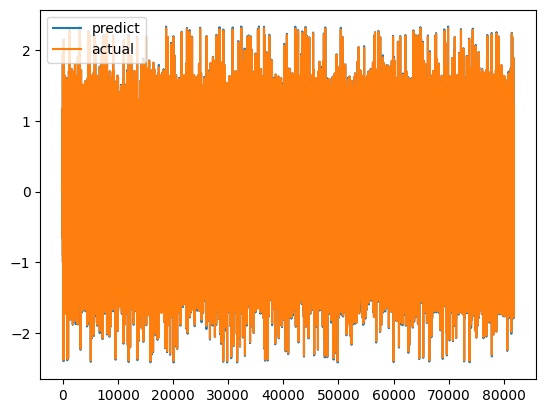

Test RMSE: 0.555


In [ ]:
#from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
def mean_squared_error(data1,data2):
  s=0
  for i in range(len(data1)):
    s+=(data1[i]-data2[i])**2
  s=s/len(data1)
  return s**(1/2)

set_learning_phase(0) #Inference mode
# make a prediction
yhat = model.predict(dataset.input_train,verbose=0)
yhat = np.squeeze(yhat) #(size,1) -> (size)
#get last step value
if method_scaling == 0: #standardization
  yhat = [dataset.sigma_output*y[-1]+dataset.mean_output for y in yhat]
  label_train_eval = [dataset.sigma_output*y[-1]+dataset.mean_output for y in dataset.label_train]
elif method_scaling == 1: #standardization
  yhat = [(dataset.max_output-dataset.min_output)*y[-1]+dataset.min_output for y in yhat]
  label_train_eval = [((dataset.max_output-dataset.min_output)*y[-1]+dataset.min_output) for y in dataset.label_train]
plt.plot(yhat,label="predict")
plt.plot(label_train_eval,label="actual")
plt.legend()
plt.show()
# calculate RMSE
rmse_test = mean_squared_error(yhat,dataset.label_train[:,-1])
#rmse_train = mean_squared_error(inv_y_train, inv_yhat_train)
print('Test RMSE: %.3f' % rmse_test)
#print('Train RMSE: %.3f' % rmse_train)

### Check accuracy with test data

In [ ]:
print(dataset.input_test[0][-1][1])

0.14774073579811794


/usr/local/lib/python3.10/dist-packages/tensorflow/python/keras/backend.py:427: UserWarning: `tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.
  warnings.warn('`tf.keras.backend.set_learning_phase` is deprecated and '


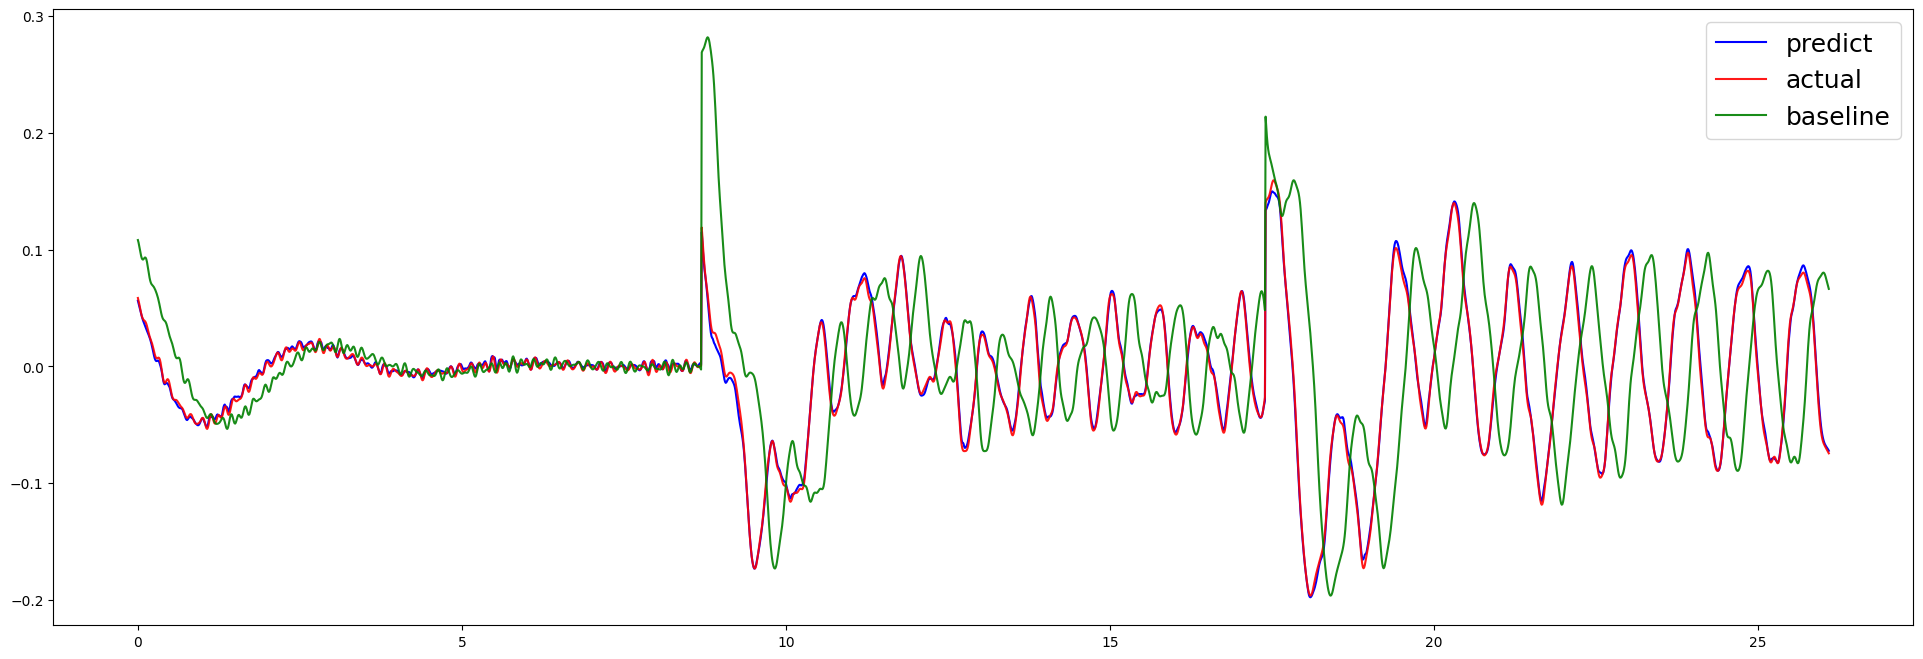

2610
(2610,)


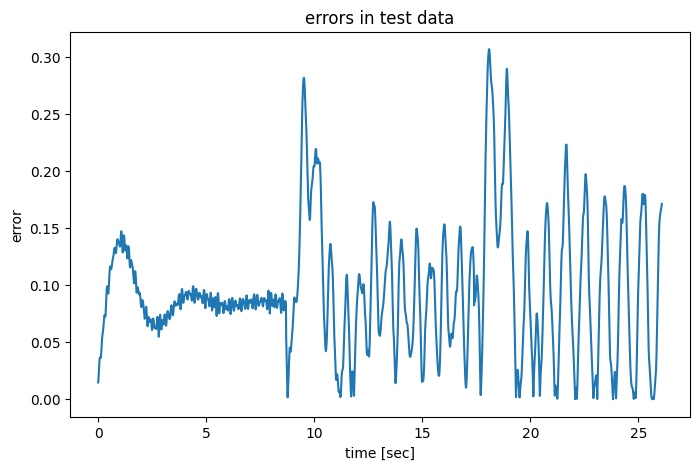

Test RMSE: 0.112
2610
(2610,)


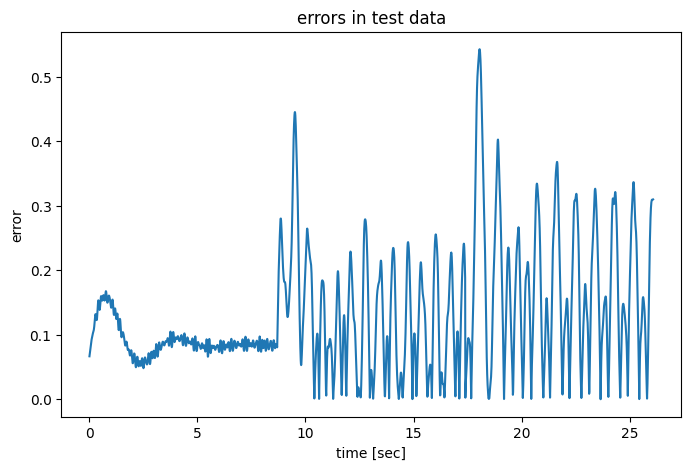

Baseline::  RMSE: 0.162


In [ ]:
#from numpy import concatenate
import math
from sklearn.metrics import mean_squared_error
def mean_squared_error(data1,data2):
  print(len(data1))
  print(data2.shape)
  s=0
  errors = []
  time = []
  for i in range(len(data1)):
    s+=(data1[i]-data2[i])**2
    errors.append(abs(data1[i]-data2[i]))
    time.append(0.01*i)
  s=s/len(data1)
  plt.figure(figsize=(8,5))
  plt.plot(time,errors)
  plt.xlabel("time [sec]")
  plt.ylabel("error")
  plt.title("errors in test data")
  plt.savefig("error_test.png")
  plt.show()
  return s**(1/2)

set_learning_phase(0) #Inference mode
data_base_line = [dataset.sigma_output*dataset.input_test[i][-1][1]+dataset.mean_output for i in range(dataset.input_test.shape[0])]
# make a prediction
yhat = model.predict(dataset.input_test,verbose=0)
yhat = np.squeeze(yhat) #(size,1) -> (size)
if method_scaling == 0: #standardization
  yhat = [dataset.sigma_output*y[-1]+dataset.mean_output for y in yhat]
  label_train_eval = [dataset.sigma_output*y[-1]+dataset.mean_output for y in dataset.label_test]
elif method_scaling == 1: #standardization
  yhat = [(dataset.max_output-dataset.min_output)*y[-1]+dataset.min_output for y in yhat]
  label_train_eval = [((dataset.max_output-dataset.min_output)*y[-1]+dataset.min_output) for y in dataset.label_test]
t_hat = [i/Sampling_rate for i in range(len(yhat))]
t_true = [i/Sampling_rate for i in range(len(label_train_eval))]
plt.figure(figsize=(24,8))
plt.plot(t_hat,yhat,color="b",label="predict")
plt.plot(t_true,label_train_eval,label="actual",color="r",alpha=0.9)
plt.plot(t_true,data_base_line,label="baseline",color="g",alpha=0.9)
plt.legend(loc="upper right",fontsize=18)
#plt.xlim(0,19.6)
plt.savefig("test.png")
plt.show()
# calculate RMSE
rmse_test = mean_squared_error(yhat,dataset.label_test[:,-1])
#rmse_train = mean_squared_error(inv_y_train, inv_yhat_train)
print('Test RMSE: %.3f' % rmse_test)

rmse_test = mean_squared_error(data_base_line,dataset.label_test[:,-1])
print('Baseline::  RMSE: %.3f' % rmse_test)
#print('Train RMSE: %.3f' % rmse_train)

## Prediction

### Bode plot

[0.   0.01 0.02 0.03 0.04 0.05 0.06 0.07 0.08 0.09 0.1  0.11 0.12 0.13
 0.14 0.15 0.16 0.17 0.18 0.19 0.2  0.21 0.22 0.23 0.24 0.25 0.26 0.27
 0.28 0.29 0.3  0.31 0.32 0.33 0.34 0.35 0.36 0.37 0.38 0.39 0.4  0.41
 0.42 0.43 0.44 0.45 0.46 0.47 0.48 0.49 0.5  0.51 0.52 0.53 0.54 0.55
 0.56 0.57 0.58 0.59 0.6  0.61 0.62 0.63 0.64 0.65 0.66 0.67 0.68 0.69
 0.7  0.71 0.72 0.73 0.74 0.75 0.76 0.77 0.78 0.79 0.8  0.81 0.82 0.83
 0.84 0.85 0.86 0.87 0.88 0.89 0.9  0.91 0.92 0.93 0.94 0.95 0.96 0.97
 0.98 0.99 1.   1.01 1.02 1.03 1.04 1.05 1.06 1.07 1.08 1.09 1.1  1.11
 1.12 1.13 1.14 1.15 1.16 1.17 1.18 1.19 1.2  1.21 1.22 1.23 1.24 1.25
 1.26 1.27 1.28 1.29 1.3  1.31 1.32 1.33 1.34 1.35 1.36 1.37 1.38 1.39
 1.4  1.41 1.42 1.43 1.44 1.45 1.46 1.47 1.48 1.49 1.5  1.51 1.52 1.53
 1.54 1.55 1.56 1.57 1.58 1.59 1.6  1.61 1.62 1.63 1.64 1.65 1.66 1.67
 1.68 1.69 1.7  1.71 1.72 1.73 1.74 1.75 1.76 1.77 1.78 1.79 1.8  1.81
 1.82 1.83 1.84 1.85 1.86 1.87 1.88 1.89 1.9  1.91 1.92 1.93 1.94 1.95
 1.96 

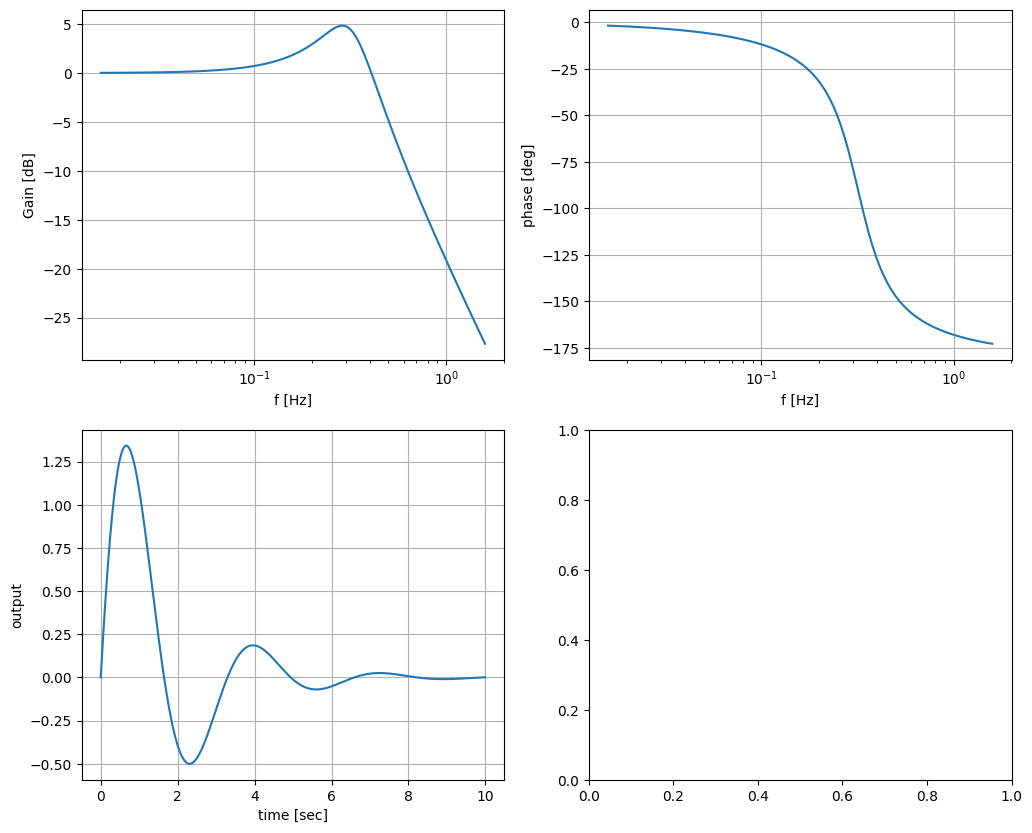

In [ ]:
import scipy
N_exercises=1
#transfer function
if N_exercises ==1:
  omega_n = 2.0  # Natural frequency
  zeta = 0.3  # Damping ratio
  G = scipy.signal.TransferFunction([0,omega_n**2], [1, 2 * zeta * omega_n, omega_n**2])
if N_exercises ==2:
  G = scipy.signal.TransferFunction([53,92.4,392],[1,9.6,63.08,92.4,196])
if N_exercises ==3:
  #Transfer Function
  num = [1,-3,-4] # numerator
  den = [1, 5,6] # denominator]
  G = signal.lti(num, den)

#Bode plots
w, bode, phase=scipy.signal.bode(G)
#Impulse response
T_im,yout_im=signal.impulse(G,T=mkData.t)
print(mkData.t)
f=w/(2.0*math.pi)


#軸表示の設定（今回は2つ左右に並べる)
fig,ax = plt.subplots(2,2,figsize=(12,10))

#左上のグラフ＝ゲイン
ax[0][0].semilogx(f,bode,label="Gain")
ax[0][0].set_ylabel('Gain [dB]')
ax[0][0].set_xlabel('f [Hz]')
ax[0][0].grid()

#右上のグラフ＝位相
ax[0][1].semilogx(f,phase)
ax[0][1].set_ylabel('phase [deg]')
ax[0][1].set_xlabel('f [Hz]')
ax[0][1].grid()

#左下のグラフ＝インパルス応答
ax[1][0].plot(T_im,yout_im)
ax[1][0].set_ylabel('output')
ax[1][0].set_xlabel('time [sec]')
ax[1][0].grid()

fig.show()

### Prediction with Impulse data
#### make impulse data

Text(0.5, 0, 'timse [sec]')

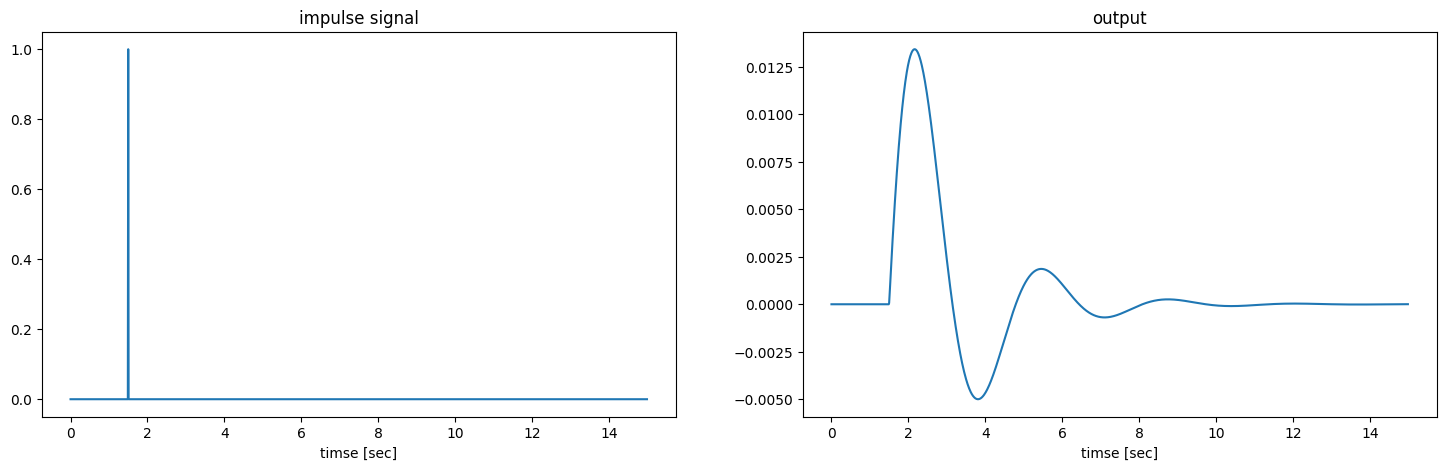

In [ ]:
import scipy.signal as signal
Start_imp = Sampling_rate+50
t = np.arange(0,1500/Sampling_rate,(1/Sampling_rate))
imp = signal.unit_impulse(t.shape[0], [Start_imp])
#output
y_out,t_out, x = control.matlab.lsim(mkData.G, U=imp,T=t)
fig,ax = plt.subplots(1,2,figsize=(18,5))
ax[0].plot(t,imp)
ax[0].set_xlabel("timse [sec]")
ax[0].set_title("impulse signal")
ax[1].plot(t,y_out)
ax[1].set_title("output")
ax[1].set_xlabel("timse [sec]")

# With true values

In [ ]:

Start_frame = Lookback_+Dif_out_
input = np.vstack((imp[Dif_out_:Lookback_+Dif_out_],y_out[:Lookback_])).transpose()
#predict
time_predict = [i/Sampling_rate for i in range(Lookback_+Dif_out_)]
#prepare inputs and outputs storage
inputs =imp #impulse input
outputs = y_out #prepare first 100 data for predict
predicts=y_out[:(Lookback_+Dif_out_)]
for i in range(Lookback_+Dif_out_,t.shape[0]):
  if i%100==0:
    print(f"{i}-th frame, outputs.shape={outputs.shape}")
  #normalize data
  input = (inputs[(i-Lookback_):(i)] - dataset.mean_input)/dataset.sigma_input
  output = (outputs[(i-Lookback_-Dif_out_):(i-Dif_out_)] - dataset.mean_output)/ dataset.sigma_output
  input_model = np.vstack((input,output)).transpose()
  input_model = np.expand_dims(input_model,0)#for converting shape into (1,100,2)
  #print(input_model.shape,input.shape,output.shape)
  #predict
  set_learning_phase(0) #Inference mode
  # make a prediction
  yhat = model.predict(input_model, verbose=0)
  yhat = np.squeeze(yhat,axis=0) #convert shape :: (1,31) -> (1)
  time_predict.append((i+1)/Sampling_rate) #save prediction time
  #convert prediction data into non-normalized one
  yhat = yhat[-1]*dataset.sigma_output+dataset.mean_output
  #add prediction data to predicts and outputs
  predicts= np.append(predicts,yhat)

predicts = np.array(predicts)
time_predicts = np.array(time_predict)

200-th frame, outputs.shape=(1500,)
300-th frame, outputs.shape=(1500,)
400-th frame, outputs.shape=(1500,)
500-th frame, outputs.shape=(1500,)
600-th frame, outputs.shape=(1500,)
700-th frame, outputs.shape=(1500,)
800-th frame, outputs.shape=(1500,)
900-th frame, outputs.shape=(1500,)
1000-th frame, outputs.shape=(1500,)
1100-th frame, outputs.shape=(1500,)
1200-th frame, outputs.shape=(1500,)
1300-th frame, outputs.shape=(1500,)
1400-th frame, outputs.shape=(1500,)


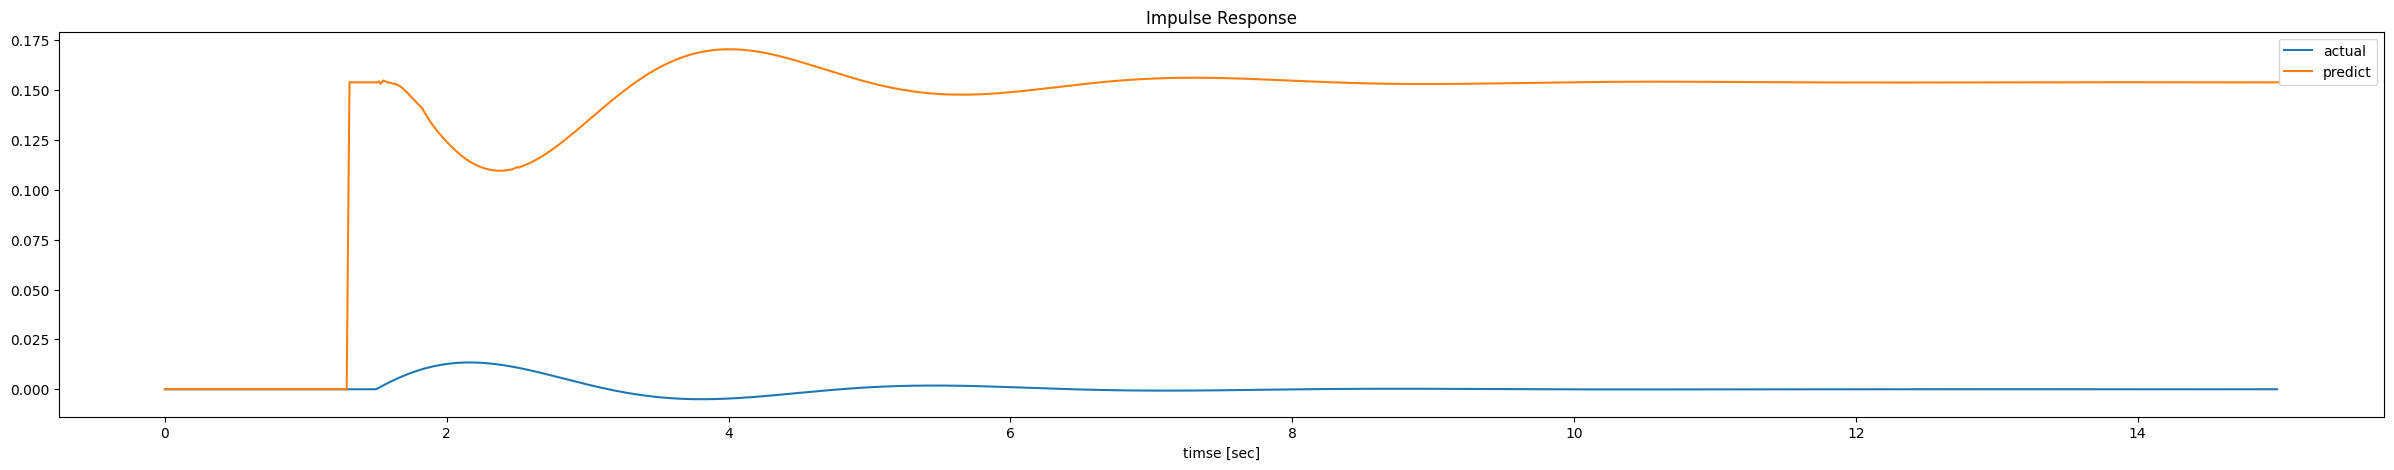

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(t,y_out,label="actual")
plt.plot(time_predict,predicts,label="predict")
plt.title("Impulse Response")
#plt.xlim(0,5)
#plt.ylim(-0.05,0.1)
plt.xlabel("timse [sec]")
plt.legend(loc="upper right")
plt.savefig("impulse.png")
plt.show()

MAE= 0.025916


Text(0.5, 0, 'timse [sec]')

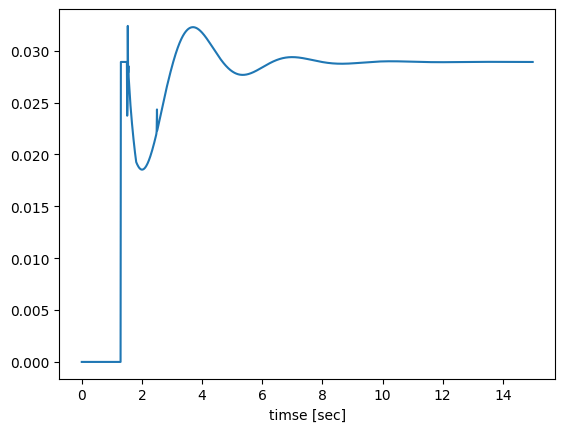

In [ ]:
frame = len(time_predict)
error = []
length=min(y_out.shape[0],predicts.shape[0])
err_sum=0
time = []
for i in range(length):
  err=abs(predicts[i]-y_out[i])
  err_sum+=err
  error.append(err)
  time.append(i/Sampling_rate)
print("MAE=",round(err_sum/length,6))
plt.plot(time,error)
plt.xlabel("timse [sec]")

In [ ]:

Start_frame = Lookback_+Dif_out_
input = np.vstack((imp[Dif_out_:Lookback_+Dif_out_],y_out[:Lookback_])).transpose()
#predict
time_predict = [i/Sampling_rate for i in range(Lookback_+Dif_out_)]
#prepare inputs and outputs storage
inputs =imp #impulse input
outputs = y_out[:(Lookback_+Dif_out_)] #prepare first 100 data for predict
predicts=y_out[:(Lookback_+Dif_out_)]
for i in range(Lookback_+Dif_out_,t.shape[0]):
  if i%100==0:
    print(f"{i}-th frame, outputs.shape={outputs.shape}")
  #normalize data
  input = (inputs[(i-Lookback_):(i)] - dataset.mean_input)/dataset.sigma_input
  output = (outputs[(i-Lookback_-Dif_out_):(i-Dif_out_)] - dataset.mean_output)/ dataset.sigma_output
  input_model = np.vstack((input,output)).transpose()
  input_model = np.expand_dims(input_model,0)#for converting shape into (1,100,2)
  #print(input_model.shape,input.shape,output.shape)
  #predict
  set_learning_phase(0) #Inference mode
  # make a prediction
  yhat = model.predict(input_model, verbose=0)
  yhat = np.squeeze(yhat,axis=0) #convert shape :: (1,31) -> (1)
  time_predict.append((i+1)/Sampling_rate) #save prediction time
  #convert prediction data into non-normalized one
  yhat = yhat[-1]*dataset.sigma_output+dataset.mean_output
  #add prediction data to predicts and outputs
  predicts= np.append(predicts,yhat)
  outputs = np.append(outputs,yhat)

predicts = np.array(predicts)
time_predicts = np.array(time_predict)

200-th frame, outputs.shape=(200,)
300-th frame, outputs.shape=(300,)
400-th frame, outputs.shape=(400,)
500-th frame, outputs.shape=(500,)
600-th frame, outputs.shape=(600,)
700-th frame, outputs.shape=(700,)
800-th frame, outputs.shape=(800,)
900-th frame, outputs.shape=(900,)
1000-th frame, outputs.shape=(1000,)
1100-th frame, outputs.shape=(1100,)
1200-th frame, outputs.shape=(1200,)
1300-th frame, outputs.shape=(1300,)
1400-th frame, outputs.shape=(1400,)


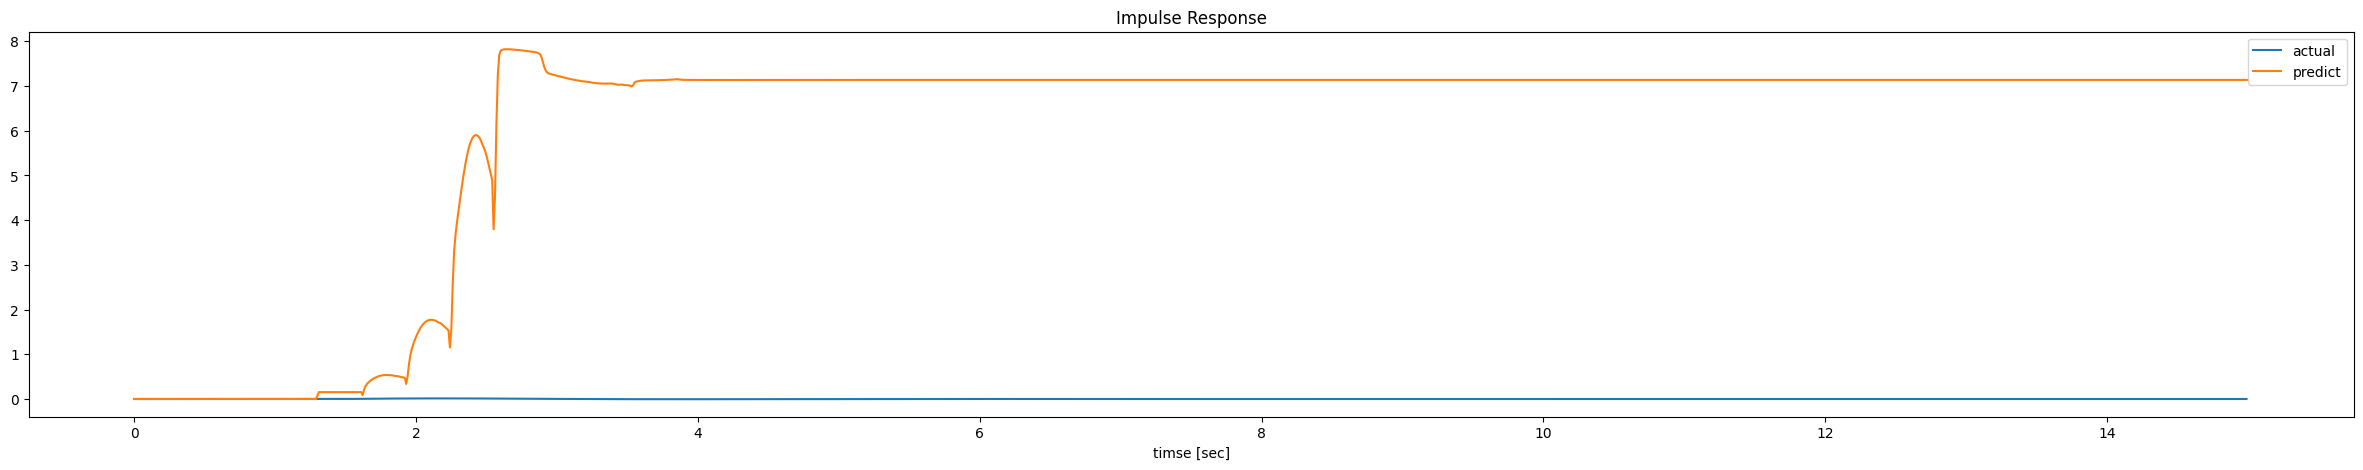

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(t,y_out,label="actual")
plt.plot(time_predict,predicts,label="predict")
plt.title("Impulse Response")
plt.xlabel("timse [sec]")
plt.legend(loc="upper right")
plt.savefig("impulse.png")
plt.show()

In [ ]:
Start_frame = Lookback_+Dif_out_
input = np.vstack((imp[Dif_out_:Lookback_+Dif_out_],y_out[:Lookback_])).transpose()
#predict
time_predict = [i/Sampling_rate for i in range(Lookback_+Dif_out_)]
#prepare inputs and outputs storage
inputs =imp #impulse input
outputs = y_out[:(Lookback_+Dif_out_)] #prepare first 100 data for predict
predicts=y_out[:(Lookback_+Dif_out_)]

frame_start = Lookback_+Dif_out_
frame_end = t.shape[0]
batch_size = 16
if (t.shape[0]-Lookback_+Dif_out_)%16==0:
  n_batch = (t.shape[0]-Lookback_+Dif_out_)//16
else:
  n_batch = (t.shape[0]-Lookback_+Dif_out_)//16+1

for i in range(n_batch):#batch prediction
  if i%100==0:
    print(f"{i}-th frame, outputs.shape={outputs.shape}")
  if (frame_end-frame_start)-i*batch_size>=batch_size:
    size=batch_size
  else:
    size=(frame_end-frame_start)-i*batch_size
  inputs_model = np.zeros((batch_size,Lookback_,2))#16,100,2
  for j in range(size):
    #normalize data
    print(inputs.shape)
    input = (inputs[((i*batch_size+j)-Lookback_):(i*batch_size+j)] - dataset.mean_input)/dataset.sigma_input
    output = (outputs[((i*batch_size+j)-Lookback_-Dif_out_):((i*batch_size+j)-Dif_out_)] - dataset.mean_output)/ dataset.sigma_output
    print(input.shape,output.shape)
    input_model = np.vstack((input,output)).transpose()
    inputs_model[j,:,:]=input_model
    print(input_model.shape)
    #input_model = np.expand_dims(input_model,0)#for converting shape into (1,100,2)
  #print(input_model.shape,input.shape,output.shape)
  #predict
  set_learning_phase(0) #Inference mode
  # make a prediction
  yhats = model.predict(inputs_model, verbose=0)
  print(yhats.shape)
  #print(yhat.shape)
  #yhat = np.squeeze(yhat,axis=0) #convert shape :: (16,31) -> (1)
  #print(yhat.shape)
  time_predict.append((i+1)/Sampling_rate) #save prediction time
  #convert prediction data into non-normalized one
  for yhat in yhats:
    yhat = yhat[-1]*dataset.sigma_output+dataset.mean_output
    #print(yhat)
    #add prediction data to predicts and outputs
    predicts= np.append(predicts,yhat)
    if i<Lookback_+Dif_out_+300:#add true value until LSTM prediction become stable.
      outputs=np.append(outputs,y_out[(i)])
    else:
      outputs = np.append(outputs,yhat)

predicts = np.array(predicts)
time_predicts = np.array(time_predict)

0-th frame, outputs.shape=(130,)
(1500,)
(0,) (100,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 0 and the array at index 1 has size 100

#### Plot predicion result

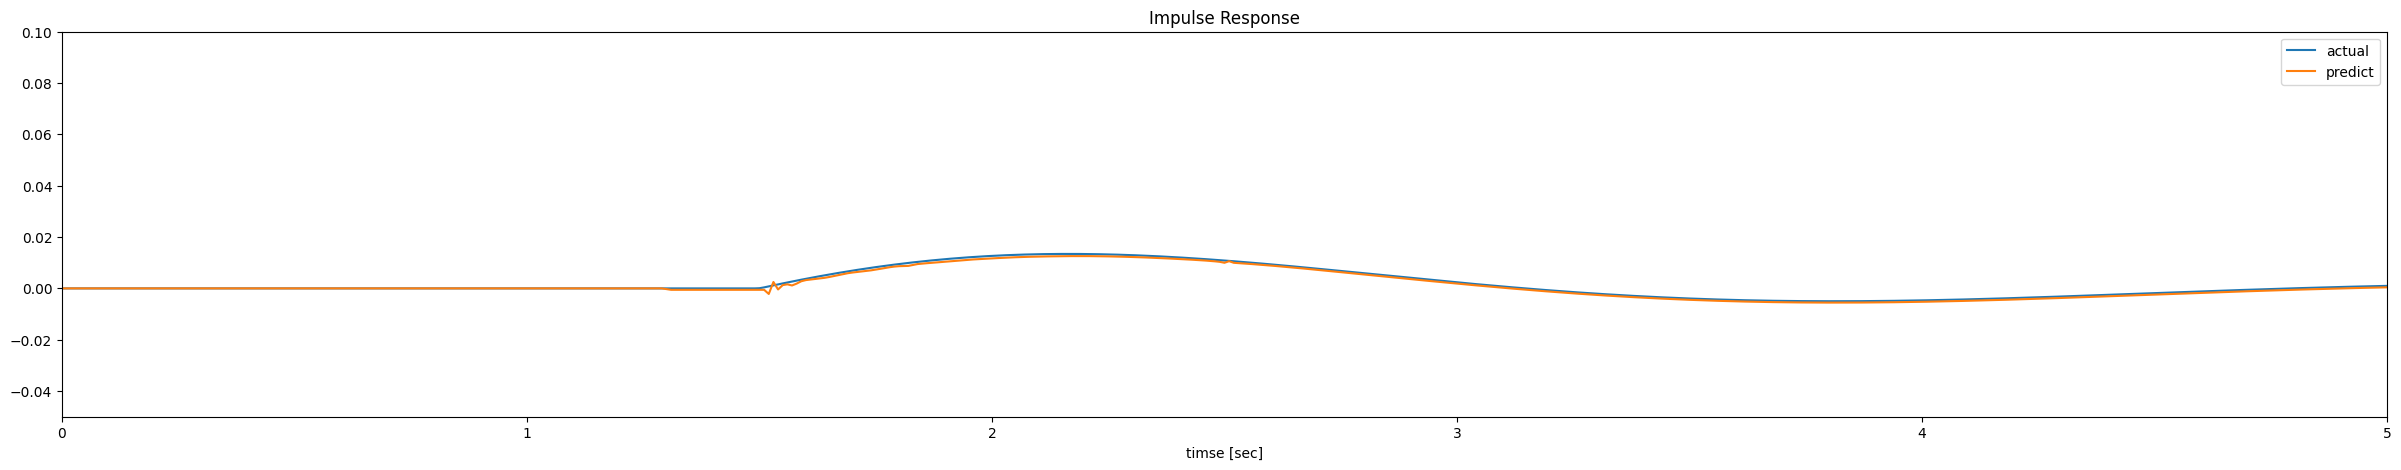

In [ ]:
plt.figure(figsize=(30,5))
plt.plot(t,y_out,label="actual")
plt.plot(time_predict,predicts,label="predict")
plt.title("Impulse Response")
plt.xlim(0,5)
plt.ylim(-0.05,0.1)
plt.xlabel("timse [sec]")
plt.legend(loc="upper right")
plt.savefig("impulse.png")
plt.show()

## plot a bode plot

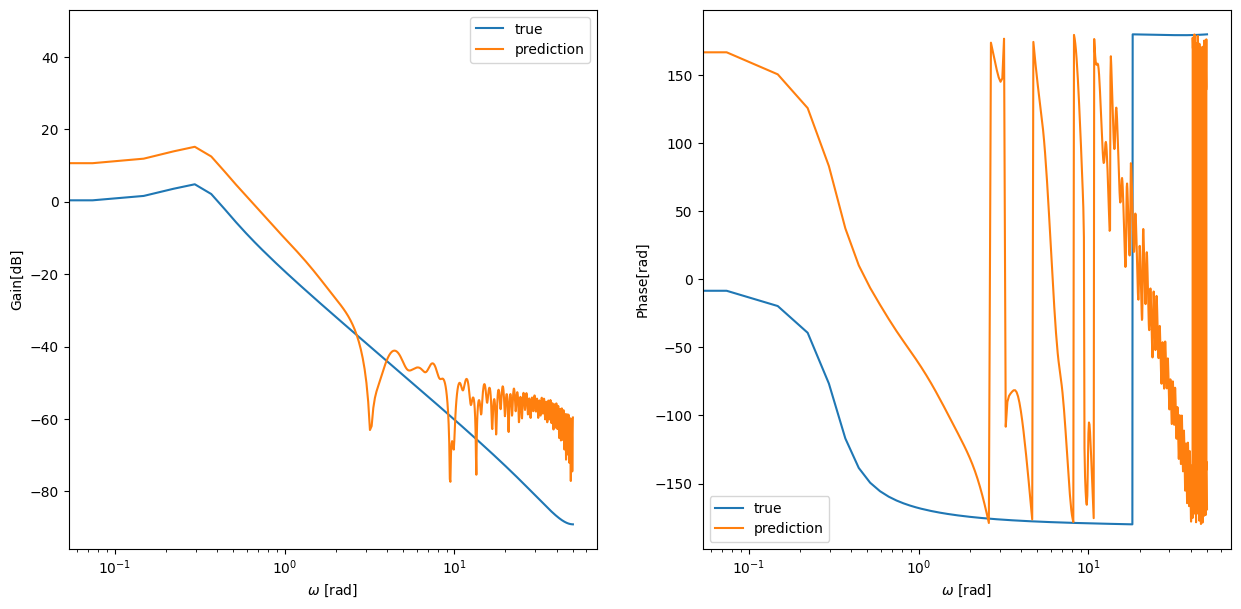

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cmath
import scipy

#what should be analyzed
data_true = y_out[Start_imp:]
data_pred = predicts[Start_imp:]

# Compute the FFT
fft_true = np.fft.fft(data_true)
fft_pred = np.fft.fft(data_pred)

# Compute the frequency bins
n_true = data_true.shape[0]
n_pred = data_pred.shape[0]
frequencies_true = np.fft.fftfreq(n_true, d=1/Sampling_rate)
frequencies_pred = np.fft.fftfreq(n_pred, d=1/Sampling_rate)

# Only take the positive half of the spectrum
positive_frequencies_true = frequencies_true[:n_true// 2]
positive_frequencies_pred = frequencies_pred[:n_pred//2]

#fft result for positive fft
fft_true = fft_true[:n_true//2]
fft_pred = fft_pred[:n_pred//2]

gains_true = [20*math.log10(abs(val)) for val in fft_true] #20*log10((alpha**2+beta**2)**(0.5))
phases_true = [180/math.pi*cmath.phase(val) for val in fft_true]
gains_pred = [20*math.log10(abs(val)) for val in fft_pred] #20*log10((alpha**2+beta**2)**(0.5))
phases_pred = [180/math.pi*cmath.phase(val) for val in fft_pred]


N_exercises=1
#transfer function
if N_exercises ==1:
  omega_n = 2.0  # Natural frequency
  zeta = 0.3  # Damping ratio
  G_gt = scipy.signal.TransferFunction([0,omega_n**2], [1, 2 * zeta * omega_n, omega_n**2])
if N_exercises ==2:
  G_gt = scipy.signal.TransferFunction([53,92.4,392],[1,9.6,63.08,92.4,196])
if N_exercises ==3:
  #Transfer Function
  num = [1,-3,-4] # numerator
  den = [1, 5,6] # denominator]
  G_gt = signal.lti(num, den)

#Bode plots
w, bode, phase=scipy.signal.bode(G_gt)
f=w/(2.0*math.pi)

fig,ax = plt.subplots(1,2,figsize=(15,7))
#gain
ax[0].semilogx(positive_frequencies_true,gains_true,label="true")
#ax[0].semilogx(f,bode,label="actual")
ax[0].semilogx(positive_frequencies_pred,gains_pred,label="prediction")

#phase
ax[1].semilogx(positive_frequencies_true,phases_true,label="true")
ax[1].semilogx(positive_frequencies_pred,phases_pred,label="prediction")
#ax[1].semilogx(f,phase,label="true")
for i in range(2):
  ax[i].set_xlabel('$\omega$ [rad]')
ax[0].set_ylabel('Gain[dB]')
ax[1].set_ylabel('Phase[rad]')
ax[0].legend()
ax[1].legend()
fig.savefig("bodePlot.png")
fig.show()

In [ ]:
f_true = np.argmax(gains_true)
f_pred = np.argmax(gains_pred)
frequency_true = positive_frequencies_true[f_true]
frequency_pred = positive_frequencies_pred[f_pred]
print("true=",frequency_true,",pred=",frequency_pred)

true= 0.2962962962962963 ,pred= 0.2962962962962963


## plot prediction with sin input

In [ ]:
N_periods = 50 #20 periods
frequency = 3.0 #2.0 Hz

In [ ]:
#make data
t = np.arange(0,1/frequency*N_periods,1/Sampling_rate)
#make sine inputs
state_init = np.zeros((Lookback_+Dif_out_))
#make input and output storage
inputs= np.append(state_init,np.sin(2*math.pi*t*frequency))
t = np.array([i/Sampling_rate for i in range(inputs.shape[0])])
#output
y_out,t_out, x = control.matlab.lsim(mkData.G, U=inputs,T=t)

Start_frame = Lookback_+Dif_out_
input = np.vstack((inputs[Dif_out_:Lookback_+Dif_out_],y_out[:Lookback_])).transpose()
#predict
time_predict = [i/Sampling_rate for i in range(Start_frame)]
#prepare inputs and outputs storage
inputs =imp #impulse input
outputs = y_out[:(Lookback_+Dif_out_)] #prepare first 100 data for predict
predicts=y_out[:(Lookback_+Dif_out_)]
for i in range(Lookback_+Dif_out_,t.shape[0]):
  if i%100==0:
    print(f"{i}-th frame, outputs.shape={outputs.shape}")
  #normalize data
  input = (inputs[(i-Lookback_):(i)] - dataset.mean_input)/dataset.sigma_input
  output = (outputs[(i-Lookback_-Dif_out_):(i-Dif_out_)] - dataset.mean_output)/ dataset.sigma_output
  input_model = np.vstack((input,output)).transpose()
  input_model = np.expand_dims(input_model,0)#for converting shape into (1,100,2)
  #print(input_model.shape,input.shape,output.shape)
  #predict
  set_learning_phase(0) #Inference mode
  # make a prediction
  yhat = model.predict(input_model, verbose=0)
  yhat = np.squeeze(yhat,axis=0) #convert shape :: (1,1) -> (1)
  time_predict.append((i+1)/Sampling_rate) #save prediction time
  #convert prediction data into non-normalized one
  yhat = yhat[-1]*dataset.sigma_output+dataset.mean_output
  #add prediction data to predicts and outputs
  predicts = np.append(predicts,yhat)
  outputs = np.append(outputs,yhat)

predicts = np.array(predicts)
time_predicts = np.array(time_predict)

200-th frame, outputs.shape=(200,)
300-th frame, outputs.shape=(300,)
400-th frame, outputs.shape=(400,)
500-th frame, outputs.shape=(500,)


ValueError: all the input array dimensions except for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 99 and the array at index 1 has size 100

### plot prediction result

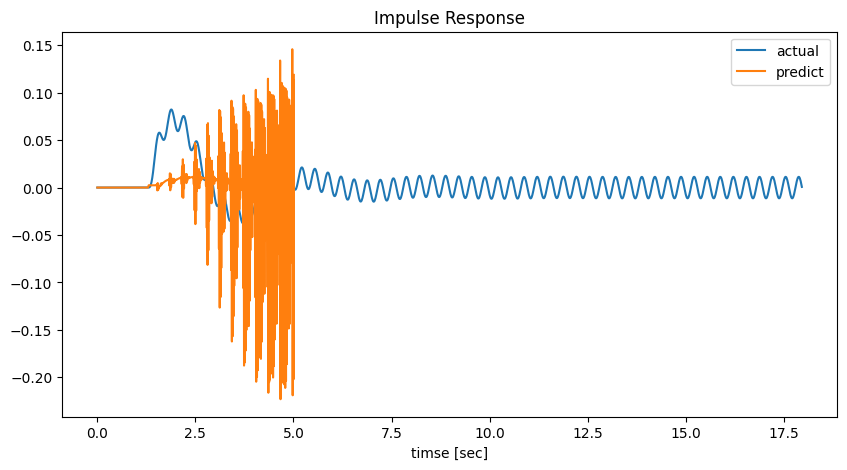

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(t,y_out,label="actual")
plt.plot(time_predict,predicts,label="predict")
plt.title("Impulse Response")
plt.xlabel("timse [sec]")
plt.legend(loc="upper right")
plt.savefig("sin_predict.png")
plt.show()

### Plot bode plot based on trained model

#### define functin for predicting

In [ ]:
def predict(model,t,inputs,outputs):
  """predict based on inputs and outputs
  Args:
    model : sequential ML model
    inputs (nd.array) : input data shape=(n_samples)
    outputs (nd.array) : storage for output data shape=(Lookback_+Dif_out_)
  Return:
    outputs (nd.array) : return outputs data. shape=(n_samples)
  """
  time_predict=[]
  for i in range(Lookback_+Dif_out_,t.shape[0]):
    if i%100==0:
      print(f"{i}-th frame, outputs.shape={outputs.shape}")
    predicts=[]
    #normalize data
    input = (inputs[(i-Lookback_):(i)] - dataset.mean_input)/dataset.sigma_input
    output = (outputs[(i-Lookback_-Dif_out_):(i-Dif_out_)] - dataset.mean_output)/ dataset.sigma_output
    input_model = np.vstack((input,output)).transpose()
    input_model = np.expand_dims(input_model,0)#for converting shape into (1,100,2)
    #print(input_model.shape,input.shape,output.shape)
    #predict
    set_learning_phase(0) #Inference mode
    # make a prediction
    yhat = model.predict(input_model, verbose=0)
    yhat = np.squeeze(yhat,axis=0) #convert shape :: (1,1) -> (1)
    time_predict.append((i+1)/Sampling_rate) #save prediction time
    #convert prediction data into non-normalized one
    yhat = yhat*dataset.sigma_output+dataset.mean_output
    #add prediction data to predicts and outputs
    predicts.append(yhat)
    outputs = np.append(outputs,yhat)
  print(f"inputs shape= {inputs.shape}, outputs shape={outputs.shape}")
  return outputs

#### Execution

In [ ]:
freq=np.linspace(0.1, 10, num=10)#frequenct range
state_init = np.zeros((Lookback_+Dif_out_))
N_periods = 10

gain_li=[]#ゲイン、プロット用
phase_li=[]#位相、プロット用

#PID controller for the output converging
kp_ident=2#2
kd_ident=0.01#0.01
ki_ident=2
C_fb=control.matlab.tf([kd_ident,kp_ident,ki_ident],[1,0])

#feedback control for the output to converge
G_dy = control.matlab.feedback(mkData.G,C_fb,sign=-1) #output
G_du = 1/(1+mkData.G*C_fb) #input

import scipy
N_exercises=1
#transfer function
if N_exercises ==1:
  omega_n = 2.0  # Natural frequency
  zeta = 0.3  # Damping ratio
  G = scipy.signal.TransferFunction([0,omega_n**2], [1, 2 * zeta * omega_n, omega_n**2])
if N_exercises ==2:
  G = scipy.signal.TransferFunction([53,92.4,392],[1,9.6,63.08,92.4,196])
if N_exercises ==3:
  #Transfer Function
  num = [1,-3,-4] # numerator
  den = [1, 5,6] # denominator]
  G = signal.lti(num, den)
#Bode plots

#for each frequency check the responses
for f in freq:
  #正弦波の周期*500だけの時間を作る
  Td=np.arange(0,1/f*N_periods,1/Sampling_rate)

  #make input and output storage
  inputs= np.append(state_init,np.sin(2*math.pi*f*Td))
  #print(inputs.shape)
  outputs = state_init
  Td = np.append(np.zeros(state_init.shape[0]),Td)
  print(Td.shape,inputs.shape,outputs.shape)
  #analyze response
  y = predict(model=model,t=Td,inputs=inputs,outputs=outputs)
  u = inputs

  #両方をFFT変換しゲイン・位相を取る
  # 窓関数
  y_start=int(len(y)/2)
  y_end=len(y)
  wf = signal.hann(y_end-y_start)# ハニング窓

  #FFT
  y_fft=np.fft.rfft(y[y_start:y_end])
  u_fft=np.fft.rfft(u[y_start:y_end])

  #y
  gain_y = max(np.abs(y_fft)) #ゲイン
  max_index_y=np.argmax(y_fft) #ゲインを取るときのデータインデックス
  im_y=y_fft[max_index_y].imag #虚部
  re_y=y_fft[max_index_y].real #実部
  phase_y=math.atan2(im_y,re_y) #位相

  #u
  gain_u = max(np.abs(u_fft))
  max_index_u=np.argmax(u_fft)
  im_u=u_fft[max_index_u].imag
  re_u=u_fft[max_index_u].real
  phase_u=math.atan2(im_u,re_u)

  #ゲイン差・位相差を取る
  gain=20*np.log10(gain_y/gain_u)
  phase=(phase_y-phase_u)*180/math.pi

  #取った差をリストに入れる
  gain_li.append(gain)
  phase_li.append(phase)

plt.figure(figsize=(10,5))
plt.plot(Td,u,label="input")
plt.plot(Td,y,label="output")
plt.legend(loc="upper right")
plt.show()
fig2,ax2=plt.subplots(2,1)
ax2[0].semilogx(freq,gain_li)#周波数-ゲイン
ax2[0].set_xlabel("w[Hz]")
ax2[0].set_ylabel("Gain[dB]")
ax2[1].semilogx(freq,phase_li)#周波数-位相
ax2[1].set_xlabel("w [Hz]")




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import hann
import matplotlib.pyplot as plt

# Define the length of the window
y_start = 0
y_end = 100
window_length = y_end - y_start

# Create the Hann window
window = hann(window_length)

print(window)

[0.         0.00100666 0.00402259 0.00903565 0.01602565 0.02496444
 0.03581603 0.04853673 0.06307531 0.07937323 0.09736487 0.11697778
 0.13813298 0.16074529 0.18472367 0.20997155 0.23638727 0.26386446
 0.29229249 0.32155689 0.35153981 0.38212053 0.41317591 0.4445809
 0.47620904 0.50793298 0.53962498 0.57115742 0.60240333 0.63323691
 0.66353398 0.69317256 0.72203331 0.75       0.77696003 0.80280484
 0.82743037 0.85073744 0.87263222 0.89302655 0.91183829 0.92899171
 0.94441772 0.95805423 0.96984631 0.97974649 0.98771489 0.99371944
 0.99773596 0.99974827 0.99974827 0.99773596 0.99371944 0.98771489
 0.97974649 0.96984631 0.95805423 0.94441772 0.92899171 0.91183829
 0.89302655 0.87263222 0.85073744 0.82743037 0.80280484 0.77696003
 0.75       0.72203331 0.69317256 0.66353398 0.63323691 0.60240333
 0.57115742 0.53962498 0.50793298 0.47620904 0.4445809  0.41317591
 0.38212053 0.35153981 0.32155689 0.29229249 0.26386446 0.23638727
 0.20997155 0.18472367 0.16074529 0.13813298 0.11697778 0.09736

<ipython-input-5-32ebb29b9282>:12: DeprecationWarning: Importing hann from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.hann' or the convenience function 'scipy.signal.get_window' instead.
  window = hann(window_length)


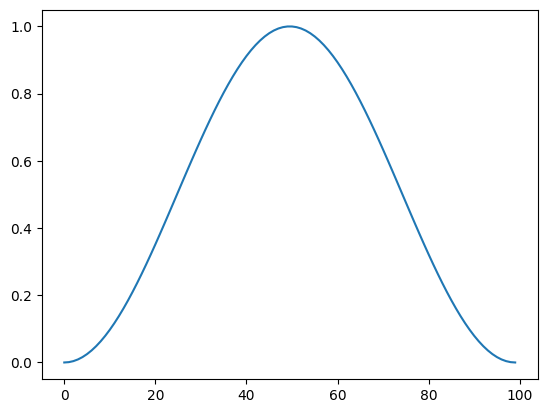

In [ ]:
freq=np.linspace(0.1, 10, num=10)#frequenct range
state_init = np.zeros((Lookback_+Dif_out_))
N_periods = 10

gain_li=[]#ゲイン、プロット用
phase_li=[]#位相、プロット用

#PID controller for the output converging
kp_ident=2#2
kd_ident=0.01#0.01
ki_ident=2
C_fb=control.matlab.tf([kd_ident,kp_ident,ki_ident],[1,0])

#feedback control for the output to converge
G_dy = control.matlab.feedback(mkData.G,C_fb,sign=-1) #output
G_du = 1/(1+mkData.G*C_fb) #input

#for each frequency check the responses
for f in freq:
  #正弦波の周期*500だけの時間を作る
  Td=np.arange(0,1/f*N_periods,1/Sampling_rate)

  #make input and output storage
  inputs= np.append(state_init,np.sin(2*math.pi*f*Td))
  #print(inputs.shape)
  outputs = state_init
  Td = np.append(np.zeros(state_init.shape[0]),Td)
  print(Td.shape,inputs.shape,outputs.shape)
  #analyze response
  y = predict(model=model,t=Td,inputs=inputs,outputs=outputs)
  u = inputs

  #両方をFFT変換しゲイン・位相を取る
  # 窓関数
  y_start=int(len(y)/2)
  y_end=len(y)
  wf = signal.hann(y_end-y_start)# ハニング窓

  #FFT
  y_fft=np.fft.rfft(y[y_start:y_end]*wf)
  u_fft=np.fft.rfft(u[y_start:y_end]*wf)

  #y
  gain_y = max(np.abs(y_fft)) #ゲイン
  max_index_y=np.argmax(y_fft) #ゲインを取るときのデータインデックス
  im_y=y_fft[max_index_y].imag #虚部
  re_y=y_fft[max_index_y].real #実部
  phase_y=math.atan2(im_y,re_y) #位相

  #u
  gain_u = max(np.abs(u_fft))
  max_index_u=np.argmax(u_fft)
  im_u=u_fft[max_index_u].imag
  re_u=u_fft[max_index_u].real
  phase_u=math.atan2(im_u,re_u)

  #ゲイン差・位相差を取る
  gain=20*np.log10(gain_y/gain_u)
  phase=(phase_y-phase_u)*180/math.pi

  #取った差をリストに入れる
  gain_li.append(gain)
  phase_li.append(phase)

plt.figure(figsize=(10,5))
plt.plot(Td,u,label="input")
plt.plot(Td,y,label="output")
plt.legend(loc="upper right")
plt.show()
fig2,ax2=plt.subplots(2,1)
ax2[0].semilogx(freq,gain_li)#周波数-ゲイン
ax2[0].set_xlabel("w[Hz]")
ax2[0].set_ylabel("Gain[dB]")
ax2[1].semilogx(freq,phase_li)#周波数-位相
ax2[1].set_xlabel("w [Hz]")

### Plot bode plots from trained model

In [ ]:
#Training session
N_exercises=1

In [ ]:
#transfer function
if N_exercises ==1:
  omega_n = 2.0  # Natural frequency
  zeta = 0.3  # Damping ratio
  G = scipy.signal.TransferFunction([0,omega_n**2], [1, 2 * zeta * omega_n, omega_n**2])
if N_exercises ==2:
  G = scipy.signal.TransferFunction([53,92.4,392],[1,9.6,63.08,92.4,196])
if N_exercises ==3:
  #Transfer Function
  num = [1,-3,-4] # numerator
  den = [1, 5,6] # denominator]
  G = signal.lti(num, den)
#Bode plots
w = np.logspace(-1,1)
w, bode, phase=scipy.signal.bode(G,w)

#軸表示の設定（今回は2つ左右に並べる)
fig,ax = plt.subplots(1,2,figsize=(10,15))

#gain -actual
ax[0].semilogx(w,bode,label="actual")
ax[0].set_ylabel('Gain [dB]')
ax[0].set_xlabel('f [Hz]')
ax[0].grid()
#phase-actual
ax[1].semilogx(w,phase,label="actual")
ax[1].set_ylabel('phase [deg]')
ax[1].set_xlabel('f [Hz]')
ax[1].grid()
#gain-predict
ax[0].semilogx(freq,gain_li,label="predict")
#phase-predict
ax[1].semilogx(freq,phase_li,label="predict")
ax[0].legend(loc="upper right")
ax[1].legend(loc="upper right")
fig.show()